# Demo for Incremental Sampler

This notebook demonstrates the incremental random sampler.

In [16]:
%matplotlib inline

import sys
import os

# Add parent directory (where pygestalt lives) to sys.path
sys.path.append(os.path.abspath(".."))

from pathlib import Path

import numpy as np
import scipy

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import *

import pygestalt as gs
from pygestalt import sampler

In [17]:
outdir = Path(os.getcwd()) / 'outputs'
os.makedirs(outdir, exist_ok=True)

## Comparison of sampling methods

We compare first different methods for generating random positions of ball.

### Method 1: iid uniform sampling

Drawback: formation of clusters

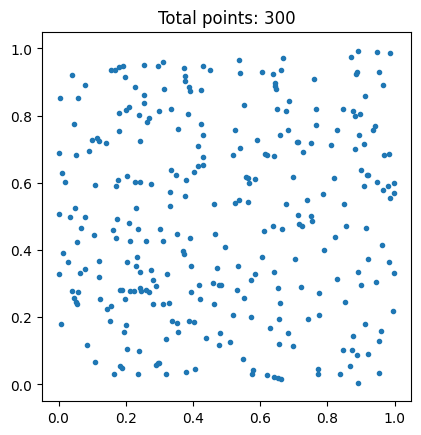

In [18]:
D = np.random.rand(300,2)
fig, ax = gs.utils.ball_plot(D)
# ax.set_axis_off()

### Method 2: random perturbation of a hexagonal grid

Depending on the amount of perturbation:
- If too few: the outcome still looks like a hex grid
- if too much: formation of clusters

In [19]:
ρ = 0.03  # 
# print(f'Radius={ρ}, Maximum number of balls={int(1/(np.pi*ρ**2))}')

N = int(1/ρ)
X, Y = np.meshgrid(np.arange(0,2*N), np.arange(-2*N,2*N))

# Hexagonal coordinates
B = np.asarray([[1,0], [0.5, np.sqrt(3)/2]]).T

H0 = np.asarray((X,Y)).reshape((2,-1)).T @ B * (2*ρ)
Hg = np.asarray([d for d in H0 if 0<=d[0]<=1 and 0<=d[1]<=1]) 

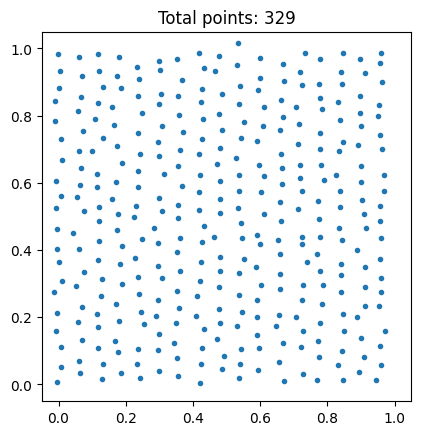

In [20]:
# change the amount of noise to see the effect of perturbation
D = Hg + np.random.randn(len(Hg),2)*ρ*0.25  # too few
# D = Hg + np.random.randn(len(Hg),2)*ρ*0.5  # too much

_ = gs.utils.ball_plot(D)

### Method 3: incremental sampling

Idea: try to randomly pack balls as many as possible inside a restricted area. 

In [21]:
sfunc = gs.sampler.box()  # random sampler
radius = 0.025  # radius of ball
thresh = 1e-3  # threshold for convergence

%time D, _ = gs.sampler.draw_positions(radius, sfunc, thresh=thresh)

CPU times: user 8.8 s, sys: 84.9 ms, total: 8.88 s
Wall time: 8.93 s


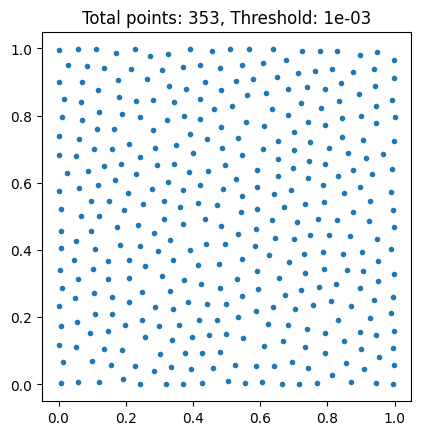

In [22]:
_ = gs.utils.ball_plot(D, thresh=thresh)

## Incremental sampling

We study the proposed method of incremental sampling.

### Effect of the threshold

The sampling becomes harder with a small threshold.

In [23]:
sfunc = gs.sampler.box()
radius = 0.1
thresh = 1e-3

%time D, _ = gs.sampler.draw_positions(radius, sfunc, thresh=thresh)

len(D)

CPU times: user 513 ms, sys: 22.8 ms, total: 536 ms
Wall time: 520 ms


28

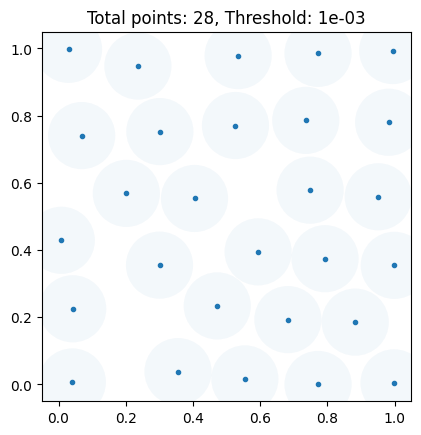

In [24]:
fig, ax = gs.utils.ball_plot(D, radius=radius, thresh=thresh)

# plt.savefig(outdir/f'thresh[{thresh:.0e}].png')

### Sampling on a restricted domain

The domain of sampling can be restricted to a curve or an area.

In [25]:
radius = 0.025
thresh = 1e-2

# First draw positions on a circle
%time C, _ = sampler.draw_positions(radius, sampler.circle(inside=False), thresh=thresh)
# Then draw background positions by excluding the circle
%time D, _ = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 65.4 ms, sys: 6.01 ms, total: 71.4 ms
Wall time: 67.1 ms
CPU times: user 897 ms, sys: 12.4 ms, total: 910 ms
Wall time: 907 ms


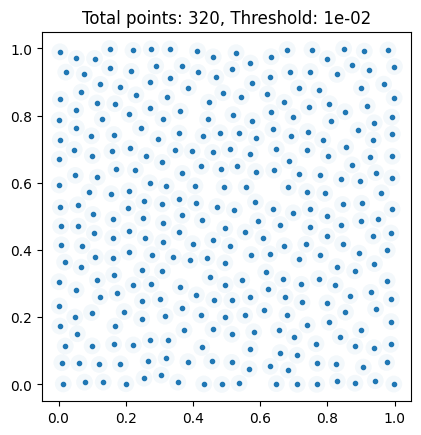

In [26]:
fig, ax = gs.utils.ball_plot(np.vstack([D, C]), radius=radius, thresh=thresh)

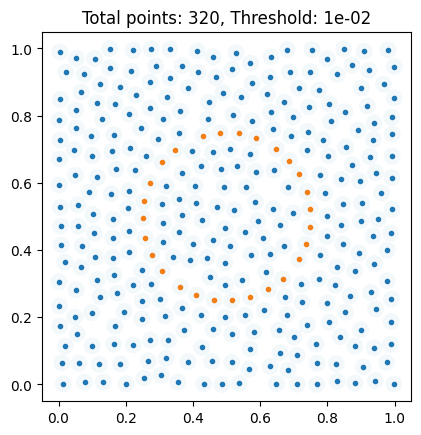

In [27]:
fig, ax = gs.utils.ball_plot(D, C, radius=radius, thresh=thresh)

#### Example with a triangle

In [28]:
P = np.asarray ([(0.25,0.25), (0.75,0.25), (0.5,0.683), (0.25,0.25)])

radius = 0.025
thresh = 1e-3

%time C, _ = sampler.draw_positions(radius, sampler.segments(P), thresh=thresh)
%time D, _ = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 591 ms, sys: 18.2 ms, total: 609 ms
Wall time: 609 ms
CPU times: user 10.1 s, sys: 119 ms, total: 10.2 s
Wall time: 10.2 s


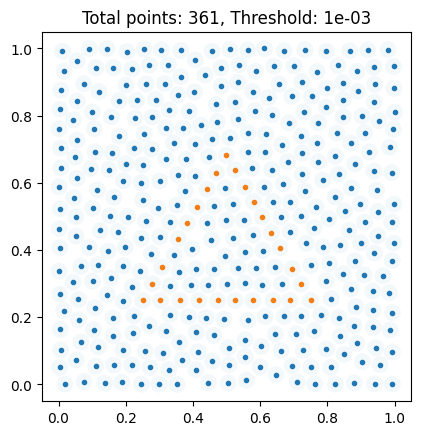

In [29]:
fig, ax = gs.utils.ball_plot(D, C, radius=radius, thresh=thresh)

### Sampling from a contour of image

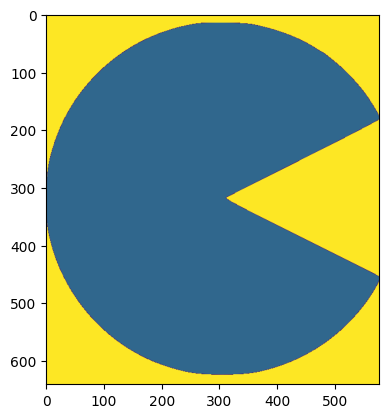

In [30]:
fname = Path('/Users/jgietema/Documents/Stage Donders/pygestalt test/datasets/pacman.png')
image = plt.imread(fname)

X0 = np.mean(image, axis=-1)
plt.imshow(X0, aspect='equal')

In [31]:
Xs, Hs = gs.utils.contour_from_image(X0)

Xs = Xs/X0.shape  # convert to the coordinate in the box [0,1]x[0,1]

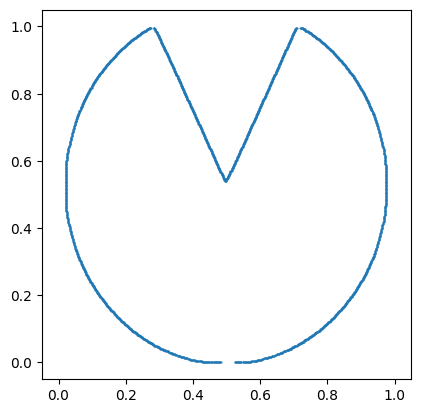

In [32]:
plt.scatter(Xs[:,0], Xs[:,1], marker='.', s=1)
ax = plt.gca()
ax.set_xlim((-0.05,1.05))
ax.set_ylim((-0.05,1.05))
ax.set_aspect('equal')   

In [33]:
radius = 0.02
thresh = 1e-3

%time C, _ = sampler.draw_positions(radius, sampler.point_set(Xs), thresh=thresh)
%time D, _ = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 1.65 s, sys: 73.2 ms, total: 1.72 s
Wall time: 1.75 s
CPU times: user 16.7 s, sys: 198 ms, total: 16.9 s
Wall time: 17 s


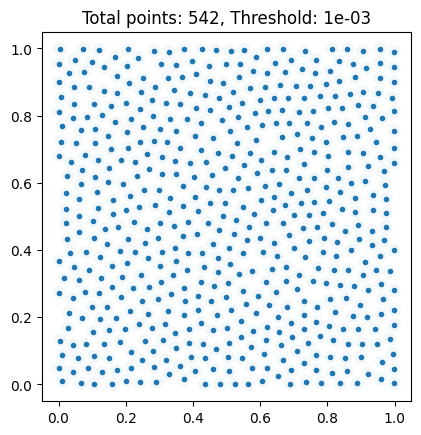

In [34]:
fig, ax = gs.utils.ball_plot(np.vstack([D,C]), radius=radius, thresh=thresh)

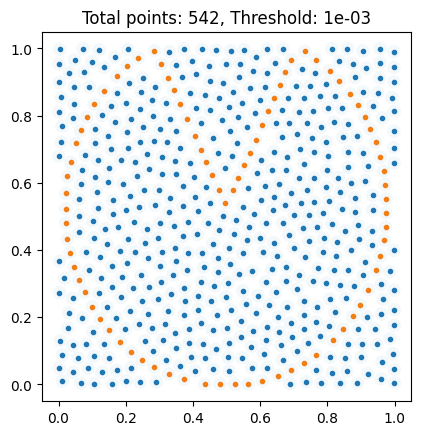

In [35]:
fig, ax = gs.utils.ball_plot(D, C, radius=radius, thresh=thresh)

# EOF